# Classical approaches

The aim of this notebook is to explain how to use the various classical models for approximating linear equations. The library implements the following methods: 
- Gauss Seidel (GS)
- Richardson iteration (RI)
- Jacobi
- Successive Over-Relaxation (SOR)
- Accelerated Over-Relaxation (AOR)
- SOR with Chebychev acceleration
- AOR with Chebychev acceleration

For more details about this approaches see this [add a link](#)

In [99]:
import matplotlib.pyplot as plt
from utils import device, generate_A_H_sol
from methods import model_iterations, GS, RI, Jacobi, SOR, SOR_CHEBY, AOR, AOR_CHEBY

Code run on : cpu


## Setting up the problem

In this example, we randomly generate a ```H``` matrix and define : 
- ```n``` : Number of rows
- ```m``` : Number of columns

We also define the number of iterations we want to have for our algorithms to converge towards a solution, as well as ```bs``` the Batch size (number of samples we use), which will be used to generate the solution to the problem.

In [23]:
# Model parameters and Parameters for evaluation of generalization error
total_itr = 25  # Total number of iterations
n = 150  # Size of matrix (rows) # ? Paramètre non ?
m = 450  # Size of matrix (columns) # ? Paramètre non ?
bs = 10  # Number of samples #? comment ca samples?
seed = 12

# Generate A and H
A, H, W, solution, y = generate_A_H_sol(n=n, m=m, seed=seed, bs=bs, device)

Condition number, min. and max. eigenvalues of A:
13.275779949832387 7.2463110961978225 0.5458294069034574


## Models

We instantiate all the approaches

In [24]:
gs_model = GS(n = n, A = A, H = H, bs = bs, y = y)
ri_model = RI(n = n, A = A, H = H, bs = bs, y = y)
Jacobi_model = Jacobi(n = n, A = A, H = H, bs = bs, y = y, omega = 0.2)
SOR_model = SOR(n = n, A = A, H = H, bs = bs, y = y, omega = 1.8)
SOR_Cheby_model = SOR_CHEBY(n = n, A = A, H = H, bs = bs, y = y, omega = 1.8, omegaa = 1.8, gamma = 0.8)
AOR_model = AOR(n = n, A = A, H = H, bs = bs, y = y, omega = 0.3, r = 0.2)
AOR_Cheby_model = AOR_CHEBY(n = n, A = A, H = H, bs = bs, y = y, omega = 0.1, r = 0.1)

We apply all the approaches on our problem and evaluate the performances at different number of iterations (1 to ```total_itr```), the evaluation is made with the MSE metrics

In [25]:
s_hat_GS, norm_list_GS = model_iterations(total_itr = total_itr, n = n, bs = bs, model = gs_model, solution = solution)
s_hat_RI, norm_list_RI = model_iterations(total_itr = total_itr, n = n, bs = bs, model = ri_model, solution = solution)
s_hat_Jacobi, norm_list_Jacobi = model_iterations(total_itr = total_itr, n = n, bs = bs, model = Jacobi_model, solution = solution)
s_hat_SOR, norm_list_SOR = model_iterations(total_itr = total_itr, n = n, bs = bs, model = SOR_model, solution = solution)
s_hat_SOR_Cheby, norm_list_SOR_Cheby = model_iterations(total_itr = total_itr, n = n, bs = bs, model = SOR_Cheby_model, solution = solution)
s_hat_AOR, norm_list_AOR = model_iterations(total_itr = total_itr, n = n, bs = bs, model = AOR_model, solution = solution)
s_hat_AOR_Cheby, norm_list_AOR_Cheby = model_iterations(total_itr = total_itr, n = n, bs = bs, model = AOR_Cheby_model, solution = solution)

## Performances visualization

In [26]:
norm_list = [norm_list_GS, norm_list_RI, norm_list_Jacobi, norm_list_SOR, norm_list_SOR_Cheby, norm_list_AOR, norm_list_AOR_Cheby]

methods = ["GS", "RI", "Jacobi", "SOR", "ChebySOR", "AOR", "ChebyAOR"]

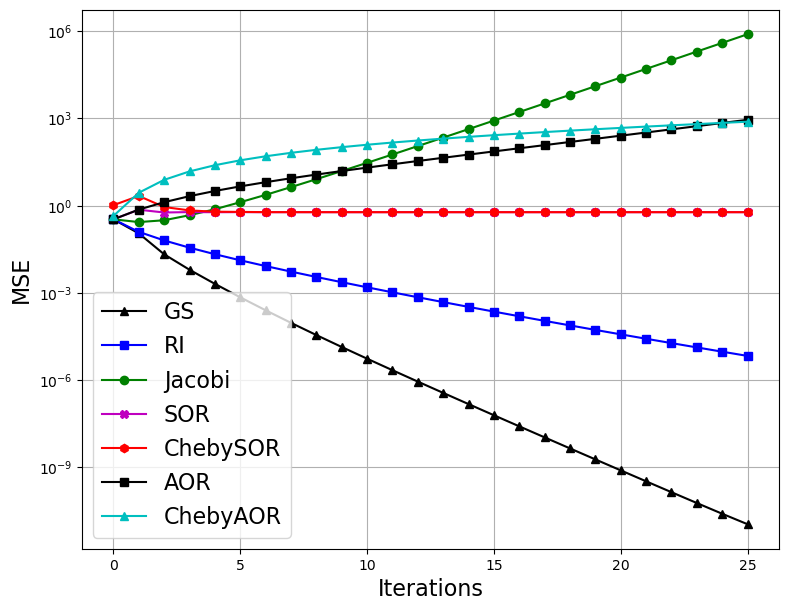

In [27]:
marker_list = ['^k-', 'sb-', 'og-', 'Xm-', 'hr-', 'sk-', '^c-', 'sr-', '^r:', '^b:', 'ok:', 'sg:', '^y:']

itr_list = list(range(len(norm_list_GS)))
plt.figure(figsize=(9,7))
for k, iterative in enumerate(norm_list):
    plt.semilogy(itr_list, iterative, marker_list[k], label=methods[k])
    plt.grid("True")
plt.legend(fontsize=16)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.yscale('log')
plt.show()